In [1]:
import matplotlib.pyplot as plt
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

In [6]:
# Example dots
dots = [
    [0,1],
    [2,1],
    [3,7],
    [2,5],
    [1,8],
    [5,0],
    [6,7],
    [2,9],
    [7,4],
    [8,2],
    [8,3],
    [7,2],
    [7,3],
    [8,4],
    [5,1],
    [6,4],
    [5,1],
    [6,4],
    [2,5],
    [9,7],
]

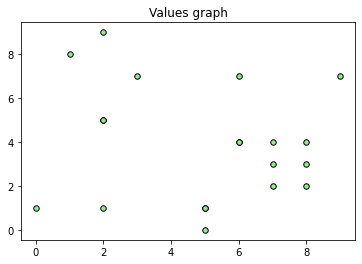

In [7]:
list_x = []
list_y = []

for i in range(len(dots)):
    list_x.append(dots[i][0])
    list_y.append(dots[i][1])

plt.scatter(list_x,list_y,
           marker='o',
           s=30,
           c='lightgreen',
           edgecolors='black')

plt.title('Values graph')
plt.show()

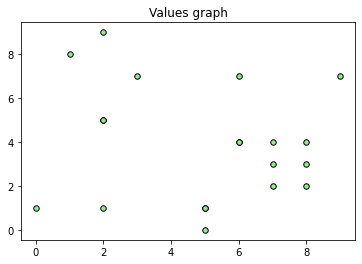

In [8]:
list_x = []
list_y = []

for i in range(len(dots)):
    list_x.append(dots[i][0])
    list_y.append(dots[i][1])

plt.scatter(list_x,list_y,
           marker='o',
           s=30,
           c='lightgreen',
           edgecolors='black')

plt.title('Values graph')
plt.show()

In [11]:
# distance_matrix 계산하는 부분

sample = [0]*len(dots)
distance_matrix = []

for i in range(len(dots)):
    single_distance_matrix = []
    if i == 0:
        distance_matrix.append(sample)
        continue
        
    for j in range(len(dots)):
        distance = abs(dots[i][0] - dots[j][0]) + abs(dots[i][1] - dots[j][1])
        single_distance_matrix.append(distance)
    
    distance_matrix.append(single_distance_matrix)
    
distance_matrix
        

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [2, 0, 7, 4, 8, 4, 10, 8, 8, 7, 8, 6, 7, 9, 3, 7, 3, 7, 4, 13],
 [9, 7, 0, 3, 3, 9, 3, 3, 7, 10, 9, 9, 8, 8, 8, 6, 8, 6, 3, 6],
 [6, 4, 3, 0, 4, 8, 6, 4, 6, 9, 8, 8, 7, 7, 7, 5, 7, 5, 0, 9],
 [8, 8, 3, 4, 0, 12, 6, 2, 10, 13, 12, 12, 11, 11, 11, 9, 11, 9, 4, 9],
 [6, 4, 9, 8, 12, 0, 8, 12, 6, 5, 6, 4, 5, 7, 1, 5, 1, 5, 8, 11],
 [12, 10, 3, 6, 6, 8, 0, 6, 4, 7, 6, 6, 5, 5, 7, 3, 7, 3, 6, 3],
 [10, 8, 3, 4, 2, 12, 6, 0, 10, 13, 12, 12, 11, 11, 11, 9, 11, 9, 4, 9],
 [10, 8, 7, 6, 10, 6, 4, 10, 0, 3, 2, 2, 1, 1, 5, 1, 5, 1, 6, 5],
 [9, 7, 10, 9, 13, 5, 7, 13, 3, 0, 1, 1, 2, 2, 4, 4, 4, 4, 9, 6],
 [10, 8, 9, 8, 12, 6, 6, 12, 2, 1, 0, 2, 1, 1, 5, 3, 5, 3, 8, 5],
 [8, 6, 9, 8, 12, 4, 6, 12, 2, 1, 2, 0, 1, 3, 3, 3, 3, 3, 8, 7],
 [9, 7, 8, 7, 11, 5, 5, 11, 1, 2, 1, 1, 0, 2, 4, 2, 4, 2, 7, 6],
 [11, 9, 8, 7, 11, 7, 5, 11, 1, 2, 1, 3, 2, 0, 6, 2, 6, 2, 7, 4],
 [5, 3, 8, 7, 11, 1, 7, 11, 5, 4, 5, 3, 4, 6, 0, 4, 0, 4, 7, 10],
 [9, 7, 6

In [12]:
def create_data_model():
    data = {}
    data['distance_matrix'] = distance_matrix
    data['num_vehicles'] = 3
    data['depot'] = 0
    return data

In [13]:
# Instance the data problem
data = create_data_model()

In [14]:
# Create the routing index manager
manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),data['num_vehicles'], data['depot'])

In [15]:
# Create the routing Model
routing = pywrapcp.RoutingModel(manager)

In [16]:
def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['distance_matrix'][from_node][to_node]

In [17]:
transit_callback_index = routing.RegisterTransitCallback(distance_callback)

In [18]:
# Define cost of each arc.
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

# Add Distance constraint.
dimension_name = 'Distance'
routing.AddDimension(
    transit_callback_index,
    0,  # no slack
    3000,  # vehicle maximum travel distance
    True,  # start cumul to zero
    dimension_name)
distance_dimension = routing.GetDimensionOrDie(dimension_name)
distance_dimension.SetGlobalSpanCostCoefficient(100)

In [19]:
# Setting first solution heuristic
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.first_solution_strategy = (
    routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

In [20]:
def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    print(f'Objective: {solution.ObjectiveValue()}')
    max_route_distance = 0
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
        route_distance = 0
        while not routing.IsEnd(index):
            plan_output += ' {} -> '.format(manager.IndexToNode(index))
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id)
        plan_output += '{}\n'.format(manager.IndexToNode(index))
        plan_output += 'Distance of the route: {}m\n'.format(route_distance)
        print(plan_output)
        max_route_distance = max(route_distance, max_route_distance)
    print('Maximum of the route distances: {}m'.format(max_route_distance))

In [21]:
# Solve the problem.
solution = routing.SolveWithParameters(search_parameters)

# Print solution on console.
if solution:
    print_solution(data, manager, routing, solution)
else:
    print('No solution found !')

Objective: 1742
Route for vehicle 0:
 0 ->  7 ->  4 -> 0
Distance of the route: 10m

Route for vehicle 1:
 0 ->  15 ->  17 ->  8 ->  12 ->  13 ->  10 ->  9 ->  11 ->  16 ->  14 ->  5 ->  1 -> 0
Distance of the route: 17m

Route for vehicle 2:
 0 ->  19 ->  6 ->  2 ->  18 ->  3 -> 0
Distance of the route: 15m

Maximum of the route distances: 17m


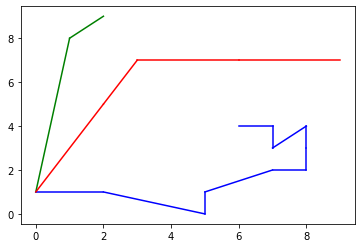

In [22]:
color_list = ['green','blue','red']
for vehicle_id in range(data['num_vehicles']):

    index = routing.Start(vehicle_id)
    index = solution.Value(routing.NextVar(index))
    previous_index = 0
    pre=dots[0]
    count = 0
    
    while not routing.IsEnd(index):
        if count == 0:
            pre=dots[index]
            index = solution.Value(routing.NextVar(index))
            previous_index = index
            count+=1
            continue
        now = dots[manager.IndexToNode(index)]
        count+=1
        plt.plot([pre[0],now[0]],[pre[1],now[1]],color_list[vehicle_id])
        pre = now
        previous_index = index
        index = solution.Value(routing.NextVar(index))
        if(routing.IsEnd(index)):
            plt.plot([now[0],0],[now[1],1],color=color_list[vehicle_id])